# **LAMIA PROJETO FINAL**

# **Bibliotecas Necessárias**

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns
import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout , BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
from keras.callbacks import ReduceLROnPlateau
import cv2
import os

# **Carregamento de dados e visualização**

This is an example of a normal lung without any cancer

In [2]:
# Import necessário
import os

# Download do dataset
from google.colab import files
print("Faça upload do arquivo kaggle.json:")
files.upload()

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia
!unzip chest-xray-pneumonia.zip -d chest_xray_data

print("Dataset baixado com sucesso!")
print("Verificando estrutura dos dados...")

# Verificar se o dataset foi baixado corretamente
dataset_path = "chest_xray_data/chest_xray"
if os.path.exists(dataset_path):
    print("✅ Dataset encontrado!")
    print(f"Pasta train: {len(os.listdir(os.path.join(dataset_path, 'train')))} subpastas")
    print(f"Pasta test: {len(os.listdir(os.path.join(dataset_path, 'test')))} subpastas")
    print(f"Pasta val: {len(os.listdir(os.path.join(dataset_path, 'val')))} subpastas")
else:
    print("❌ Erro: Dataset não encontrado!")


Faça upload do arquivo kaggle.json:


Streaming output truncated to the last 5000 lines.
  inflating: chest_xray_data/chest_xray/train/NORMAL/IM-0439-0001-0001.jpeg  
  inflating: chest_xray_data/chest_xray/train/NORMAL/IM-0439-0001-0002.jpeg  
  inflating: chest_xray_data/chest_xray/train/NORMAL/IM-0439-0001.jpeg  
  inflating: chest_xray_data/chest_xray/train/NORMAL/IM-0440-0001.jpeg  
  inflating: chest_xray_data/chest_xray/train/NORMAL/IM-0441-0001.jpeg  
  inflating: chest_xray_data/chest_xray/train/NORMAL/IM-0442-0001.jpeg  
  inflating: chest_xray_data/chest_xray/train/NORMAL/IM-0444-0001.jpeg  
  inflating: chest_xray_data/chest_xray/train/NORMAL/IM-0445-0001.jpeg  
  inflating: chest_xray_data/chest_xray/train/NORMAL/IM-0446-0001.jpeg  
  inflating: chest_xray_data/chest_xray/train/NORMAL/IM-0447-0001.jpeg  
  inflating: chest_xray_data/chest_xray/train/NORMAL/IM-0448-0001.jpeg  
  inflating: chest_xray_data/chest_xray/train/NORMAL/IM-0449-0001.jpeg  
  inflating: chest_xray_data/chest_xray/train/NORMAL/IM-0450-00

In [5]:
cv2.imread("/content/chest_xray_data/chest_xray/val/PNEUMONIA/person1954_bacteria_4886.jpeg").shape

(1128, 1664, 3)

In [11]:
import os, cv2, numpy as np

labels = ['PNEUMONIA', 'NORMAL']
img_size = 150

def load_split(data_dir):
    X, y = [], []
    for label in labels:
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        if not os.path.isdir(path):
            print(f"⚠️ Pasta não encontrada: {path}")
            continue

        for fname in os.listdir(path):
            fpath = os.path.join(path, fname)
            try:
                img_arr = cv2.imread(fpath, cv2.IMREAD_GRAYSCALE)
                if img_arr is None:
                    print(f"Imagem inválida (None): {fpath}")
                    continue
                resized = cv2.resize(img_arr, (img_size, img_size))
                X.append(resized)
                y.append(class_num)
            except Exception as e:
                print(f"Erro em {fpath}: {e}")

    X = np.array(X, dtype=np.float32) / 255.0        # normaliza 0-1
    X = np.expand_dims(X, axis=-1)                   # (N, 150, 150, 1)
    y = np.array(y, dtype=np.int64)
    return X, y

# Caminhos corretos conforme seu unzip:
train_dir = "/content/chest_xray_data/chest_xray/train"
val_dir   = "/content/chest_xray_data/chest_xray/val"
test_dir  = "/content/chest_xray_data/chest_xray/test"

X_train, y_train = load_split(train_dir)
X_val,   y_val   = load_split(val_dir)
X_test,  y_test  = load_split(test_dir)

print(X_train.shape, y_train.shape)
print(X_val.shape,   y_val.shape)
print(X_test.shape,  y_test.shape)


(5216, 150, 150, 1) (5216,)
(16, 150, 150, 1) (16,)
(624, 150, 150, 1) (624,)


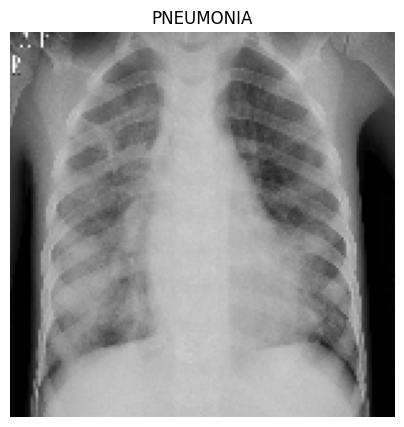

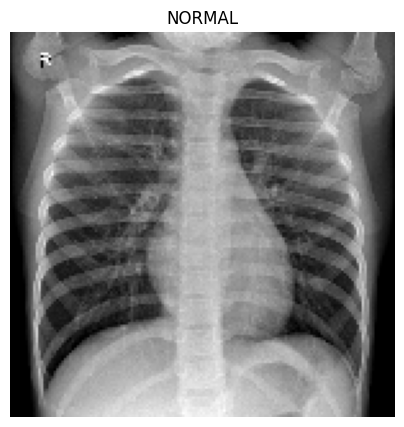

In [16]:
import matplotlib.pyplot as plt
import numpy as np

# primeira imagem do treino
plt.figure(figsize=(5,5))
plt.imshow(X_train[0].squeeze(), cmap='gray')  # (150,150)
plt.title(labels[int(y_train[0])])
plt.axis('off')
plt.show()

# última imagem do treino
plt.figure(figsize=(5,5))
plt.imshow(X_train[-1].squeeze(), cmap='gray')
plt.title(labels[int(y_train[-1])])
plt.axis('off')
plt.show()


In [20]:
x_train, y_train = X_train.astype(np.float32), y_train
x_val,   y_val   = X_val.astype(np.float32),   y_val
x_test,  y_test  = X_test.astype(np.float32),  y_test


In [21]:
# resize data for deep learning
x_train = x_train.reshape(-1, img_size, img_size, 1)
y_train = np.array(y_train)

x_val = x_val.reshape(-1, img_size, img_size, 1)
y_val = np.array(y_val)

x_test = x_test.reshape(-1, img_size, img_size, 1)
y_test = np.array(y_test)

In [22]:
# With data augmentation to prevent overfitting and handling the imbalance in dataset

datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range = 30,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.2, # Randomly zoom image
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip = True,  # randomly flip images
        vertical_flip=False)  # randomly flip images


datagen.fit(x_train)

In [27]:
model = Sequential()
model.add(Conv2D(32 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu' , input_shape = (150,150,1)))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.1))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(128 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(256 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Flatten())
model.add(Dense(units = 128 , activation = 'relu'))
model.add(Dropout(0.2))
model.add(Dense(units = 1 , activation = 'sigmoid'))
model.compile(optimizer = "rmsprop" , loss = 'binary_crossentropy' , metrics = ['accuracy'])
model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 150, 150, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 150, 150, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 75, 75, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 75, 75, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 75, 75, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 75, 75, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 38, 38, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 38, 38, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 38, 38, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 19, 19, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 19, 19, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 19, 19, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 19, 19, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 10, 10, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 10, 10, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 10, 10, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 10, 10, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 5, 5, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 6400)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       819,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴─────────────

 Total params: 1,246,401 (4.75 MB)

 Trainable params: 1,245,313 (4.75 MB)

 Non-trainable params: 1,088 (4.25 KB)

In [28]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience = 2, verbose=1,factor=0.3, min_lr=0.000001)

In [ ]:
history = model.fit(datagen.flow(x_train,y_train, batch_size = 32) ,epochs = 20 , validation_data = datagen.flow(x_val, y_val) ,callbacks = [learning_rate_reduction])

Epoch 1/20
139/163 ━━━━━━━━━━━━━━━━━━━━ 1:11 3s/step - accuracy: 0.8006 - loss: 1.0844

In [ ]:
epochs = [i for i in range(12)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
fig.set_size_inches(20,10)

ax[0].plot(epochs , train_acc , 'go-' , label = 'Training Accuracy')
ax[0].plot(epochs , val_acc , 'ro-' , label = 'Validation Accuracy')
ax[0].set_title('Training & Validation Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs , train_loss , 'g-o' , label = 'Training Loss')
ax[1].plot(epochs , val_loss , 'r-o' , label = 'Validation Loss')
ax[1].set_title('Testing Accuracy & Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Training & Validation Loss")
plt.show()

In [ ]:
print(classification_report(y_test, predictions, target_names = ['Pneumonia (Class 0)','Normal (Class 1)']))

In [ ]:
cm = confusion_matrix(y_test,predictions)
cm = pd.DataFrame(cm , index = ['0','1'] , columns = ['0','1'])
plt.figure(figsize = (10,10))
sns.heatmap(cm,cmap= "Blues", linecolor = 'black' , linewidth = 1 , annot = True, fmt='',xticklabels = labels,yticklabels = labels)

In [ ]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# supondo que suas predições são probabilidades (sigmoid ou softmax)
# para binário (NORMAL vs PNEUMONIA):
y_pred_prob = model.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype(int).ravel()  # threshold 0.5

# matriz de confusão
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(5,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Reds',
            xticklabels=labels,
            yticklabels=labels)

plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.title("Confusion Matrix - Pneumonia Detection")
plt.show()


In [ ]:
def plot_history_model(history):
    fig, axs = plt.subplots(1, 2, figsize=(15,5))

    # Accuracy
    axs[0].plot(history.history['accuracy'], 'r', label='training accuracy')
    axs[0].plot(history.history['val_accuracy'], 'b', label='validation accuracy')
    axs[0].set_title("Model's accuracy")
    axs[0].set_xlabel('Epoch')
    axs[0].set_ylabel('Accuracy')
    axs[0].legend(loc='best')

    # Loss
    axs[1].plot(history.history['loss'], 'r', label='training loss')
    axs[1].plot(history.history['val_loss'], 'b', label='validation loss')
    axs[1].set_title("Model's loss")
    axs[1].set_xlabel('Epoch')
    axs[1].set_ylabel('Loss')
    axs[1].legend(loc='best')

    plt.show()

# depois do treino:
plot_history_model(history)
